# Projekt: Titanic, survival prediction

## Inhaltsverzeichnis
- [Einleitung](#1)<br>
- [Benötigte Imports](#2)<br>
- [Laden der Datensätze](#3)<br>
- [Beschreibung des Datensatzes](#4)<br>
- [Data Exploration](#5)<br>
    - [NaN Werte verarbeiten (Embarked und Fare)](#10)
- [Feature Engineering](#6)<br>
    - [Feature: Geschlecht der Passagiere](#7)<br>
    - [Feature: Titel-Mapping](#8)<br>
    - [Feature: Ist Kind](#8)<br>
    - [Feature: Alter auffüllen](#8)<br>
    - [Feature: Familiengröße (Family_Size)](#8)<br>
    - [Feature: Überlebensrate von Familien](#9)<br>
- [Data Preprocessing](#11)<br>
- [Modells](#12)<br>
    - [K-Neares Neighbors](#12)<br>
        - [Modell-Setup](#12)<br>
        - [Modell-Training](#13)<br>
        - [Modell-Prediction](#14)<br>

<a id="1"></a>
## Einleitung

Informationen zum Notebook:

Autor: Ivan Birkmaier<br>
Martrikelnummer: 52305064<br>
Username: ai23m049<br>
____

Modul: Development Project AI<br>
Lektor: Brandmayr Georg

Projektbeschreibung: **Vorhersage der Überlebenschancen beim Titanic-Unglück**

Das Titanic-Unglück von 1912 gehört zu den bekanntesten Katastrophen der Seefahrtsgeschichte. Von den 2224 Passagieren und Besatzungsmitgliedern an Bord kamen 1502 ums Leben, als das Schiff nach der Kollision mit einem Eisberg sank. Dieses tragische Ereignis bietet einen einzigartigen Datensatz für historische und statistische Analysen. <br> 
Das Ziel dieses Projekts ist es, ein Vorhersagemodell zu entwickeln, das die Überlebenschancen der Passagiere basierend auf verfügbaren Passagierdaten einschätzt. Eine besondere Herausforderung dabei ist, dass diebereitgestellten  Daten kein Geschlecht der Passagiere beinhalten, was üblicherweise ein signifikanter Faktor in Überlebensvorhersagemodellen ist.

<a id="2"></a>
## Benötigte Imports

Im folgenden werden alle für dieses Notebook benötigten Bibliotheken eingebunden. Zusätzlich werden Bibliotheken in den gewählten Kernal installiert, sollten diese nicht vorhanden sein.

In [150]:
# Installieren der notwendigen Pakete, falls sie noch nicht installiert sind
%pip install pandas numpy seaborn requests matplotlib scikit-learn

print("\nVersionen der installierten Bibliotheken")
import pandas as pd
print('pandas:', pd.__version__)
import numpy as np
print('numpy:', np.__version__)
import seaborn as sns
print('seaborn:', sns.__version__)
import re
import requests
print('requests:', requests.__version__)
import matplotlib.pyplot as plt
# print('matplotlib:', plt.__version__)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import sklearn
print('scikit-learn:', sklearn.__version__)
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')


label_encoder = LabelEncoder()

Note: you may need to restart the kernel to use updated packages.

Versionen der installierten Bibliotheken
pandas: 2.2.1
numpy: 1.26.4
seaborn: 0.13.2
requests: 2.31.0
scikit-learn: 1.4.1.post1


<a id="3"></a>
## Laden der Datensätze

In [151]:
data_path = Path.cwd()

# Laden der Trainingsdaten
train_data = pd.read_csv(data_path/'../csv/original_data/train.csv', index_col=0)
train_data = train_data.reset_index() #um Id zu behalten als spalte

# Laden der Testdaten
test_data = pd.read_csv(data_path/'../csv/original_data/test.csv', index_col=0)
test_data = test_data.reset_index() #um Id zu behalten als spalte

# Markiere die Datensätze als 'Train' oder 'Test'
train_data['Dataset'] = 'Train'
test_data['Dataset'] = 'Test'

# Kombiniere beide Datensätze
feature_engineering_df = pd.concat([train_data, test_data], ignore_index=True)

feature_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
 11  Dataset      1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


<a id="4"></a>
## Beschreibung des Datensatzes

Die folgende Beschreibung des Datensatzes stammt aus folgender Quelle: [Titanic Dataset auf Kaggle](https://www.kaggle.com/competitions/titanic/data)


| Variable  | Definition                     | Key                                          |
|-----------|--------------------------------|----------------------------------------------|
| survival  | Survival                       | 0 = No, 1 = Yes                              |
| pclass    | Ticket class                   | 1 = 1st, 2 = 2nd, 3 = 3rd                    |
| sex       | Sex                            |                                              |
| Age       | Age in years                   |                                              |
| sibsp     | # of siblings / spouses aboard the Titanic |                                              |
| parch     | # of parents / children aboard the Titanic |                                              |
| ticket    | Ticket number                  |                                              |
| fare      | Passenger fare                 |                                              |
| cabin     | Cabin number                   |                                              |
| embarked  | Port of Embarkation            | C = Cherbourg, Q = Queenstown, S = Southampton |

**Variable Notes:**

- **pclass:** A proxy for socio-economic status (SES)
  - 1st = Upper
  - 2nd = Middle
  - 3rd = Lower
- **age:** Age is fractional if less than 1. If the age is estimated, it is in the form of xx.5.
- **sibsp:** The dataset defines family relations in this way...
  - Sibling = brother, sister, stepbrother, stepsister
  - Spouse = husband, wife (mistresses and fiancés were ignored)
- **parch:** The dataset defines family relations in this way...
  - Parent = mother, father
  - Child = daughter, son, stepdaughter, stepson
  - Some children travelled only with a nanny, therefore parch=0 for them.


<a id="5"></a>
## Date Exploration

Generelle deskriptive Kennzahlen:

In [152]:
feature_engineering_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


Überlebensrate der Trainingsdaten:

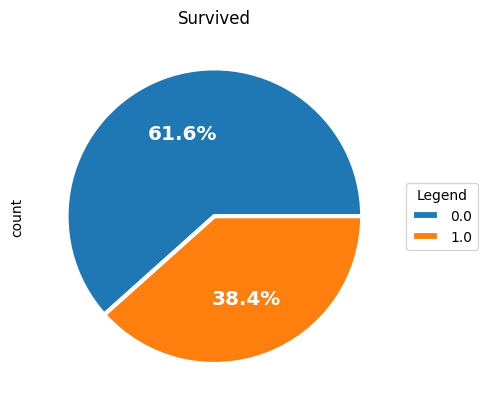

In [153]:
# Filtern der Daten, um nur Einträge zu berücksichtigen, bei denen 'Survived' nicht gleich 2 ist
filtered_df = feature_engineering_df[feature_engineering_df.Survived != 2]

# Erstellen des Kreisdiagramms auf Basis der gefilterten Daten
pie_chart = filtered_df.Survived.value_counts().plot.pie(autopct='%.1f%%', 
                                                         wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, 
                                                         textprops=dict(size='x-large', color='white', fontweight='bold'))
pie_chart.set_title('Survived')

# Hinzufügen der Legende unter Verwendung der Indizes der Serie, die nun die gefilterten Labels enthalten
labels = filtered_df.Survived.value_counts().index
plt.legend(labels, title="Legend", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()


Überlebensrate verteilt auf die unterschiedlichen Passagierklassen Survival ratio per Pclass: 

In [154]:
feature_engineering_df.groupby(['Pclass']).Survived.agg(Survivor_ratio='mean', Passengers='size')

,Survivor_ratio,Passengers
Pclass,,
1,0.629630,323
2,0.472826,277
3,0.242363,709


In [155]:
feature_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
 11  Dataset      1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


<a id="10"></a>
### NaN Werte verarbeiten (Embarked und Fare)

Insgesamt fehlen bei Embarked zwei einträge und bei Fare ein Eintrag (siehe oben).
- Embareked: Einfach Southempton (S) genommen weil da am meisten eingestiegen sind: Höhste Wahrscheinlichkeit.
- Fare: Mit dem Durchschnittsticketpreis aufgefüllt.

In [156]:
feature_engineering_df["Embarked"].fillna(value="S", inplace=True)
feature_engineering_df["Fare"].fillna(value=feature_engineering_df["Fare"].mean(), inplace=True)
feature_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1309 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1309 non-null   object 
 11  Dataset      1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


<a id="6"></a>
## Feature Engineering

<a id="7"></a>
### Feature: Geschlecht der Passagiere

Es wird versucht über den Namen der Pasagieren (mit Titel/Ansprache z.B Mr.) auf das Geschlecht der Passagiere Rückschlüsse zu ziehen. Grund hierfür ist dass aus rechereche sich ergeben hat das Frauen und Kinder vor den Männern gerettet wurden.

In [157]:
# Funktion, um Namen in ihre Bestandteile zu teilen
def split_name(name):
    parts = re.split(r'[,\. ]+', name)
    surname = parts[0]
    speech = parts[1]
    first_name = " ".join(parts[2:])
    return surname, speech, first_name

# Namen in Bestandteile aufteilen und zu DataFrame hinzufügen
feature_engineering_df[['Surname', 'Titel', 'First_Name']] = feature_engineering_df.apply(lambda x: split_name(x['Name']), axis=1, result_type='expand')

feature_engineering_df.head(2)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Titel,First_Name
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Train,Braund,Mr,Owen Harris
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Train,Cumings,Mrs,John Bradley (Florence Briggs Thayer)


Überprüfen ob das trennen der Name Spalte vollständig geklappt hat:

In [158]:
feature_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1309 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1309 non-null   object 
 11  Dataset      1309 non-null   object 
 12  Surname      1309 non-null   object 
 13  Titel        1309 non-null   object 
 14  First_Name   1309 non-null   object 
dtypes: float64(3), int64(4), object(8)
memory usage: 153.5+ KB


Überprüfung der entstandenen Titel:

In [159]:
unique_speech_values = feature_engineering_df["Titel"].unique()
print(unique_speech_values)

['Mr' 'Mrs' 'Miss' 'Master' 'Planke' 'Don' 'Rev' 'Billiard' 'der' 'Walle'
 'Dr' 'Pelsmaeker' 'Mulder' 'y' 'Steen' 'Carlo' 'Mme' 'Impe' 'Ms' 'Major'
 'Gordon' 'Messemaeker' 'Mlle' 'Col' 'Capt' 'Velde' 'the' 'Shawah'
 'Jonkheer' 'Melkebeke' 'Cruyssen' 'Khalil' 'Palmquist' 'Brito']


**Typische Titel**:
  - **'Mr'**: Ein allgemeiner Titel für einen erwachsenen Mann.
  - **'Mrs'**: Ein Titel für eine verheiratete Frau.
  - **'Miss'**: Ein Titel für eine unverheiratete Frau.
  - **'Master'**: Ein traditioneller Titel für einen jungen Mann oder Jungen, oft verwendet für Kinder.
  - **'Don'**: Ein Titel, der in einigen spanischsprachigen Ländern sowie in Italien verwendet wird, oft vor dem Vornamen.
  - **'Rev'** (Reverend): Ein religiöser Titel, verwendet für Mitglieder des Klerus.
  - **'Dr'**: Ein akademischer oder professioneller Titel für Personen, die einen Doktorgrad in einem Fachgebiet haben.
  - **'Mme'** (Madame): Ein französischer Titel für eine verheiratete Frau.
  - **'Ms'**: Ein neutraler Titel für Frauen, unabhängig vom Familienstand.
  - **'Major'**: Ein militärischer Rang.
  - **'Mlle'** (Mademoiselle): Ein französischer Titel für eine unverheiratete Frau.
  - **'Col'** (Colonel): Ein militärischer Rang.
  - **'Capt'** (Captain): Ein militärischer Rang oder ein Titel für den Kapitän eines Schiffs oder Flugzeugs.
  - **'Jonkheer'**: Ein niederländischer Adelstitel, äquivalent zu einem unbeerbten Adligen oder einem "Junker".

**Weniger typische oder kontextabhängige Titel**:
  - **'Planke'**, **'Billiard'**, **'der'**, **'Walle'**, **'Pelsmaeker'**, **'Mulder'**, **'y'**, **'Steen'**, **'Carlo'**, **'Impe'**, **'Gordon'**, **'Messemaeker'**, **'Velde'**, **'the'**, **'Shawah'**, **'Melkebeke'**, **'Cruyssen'** **'Brito'** 

Analysieren der Daten mit untypischen Titeln:

In [160]:
specific_speech_values = [
    'Planke', 'Billiard', 'der', 'Walle', 'Pelsmaeker', 'Mulder', 'y', 'Steen', 
    'Carlo', 'Impe', 'Gordon', 'Messemaeker', 'Velde', 'the', 'Shawah', 
    'Melkebeke', 'Cruyssen', 'Brito'
]

filtered_df = feature_engineering_df[feature_engineering_df['Titel'].isin(specific_speech_values)]
filtered_df

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Titel,First_Name
18,19,0.0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",31.0,1,0,345763,18.0000,NaN,S,Train,Vander,Planke,Mrs Julius (Emelia Maria Vandemoortele)
38,39,0.0,3,"Vander Planke, Miss. Augusta Maria",18.0,2,0,345764,18.0000,NaN,S,Train,Vander,Planke,Miss Augusta Maria
153,154,0.0,3,"van Billiard, Mr. Austin Blyler",40.5,0,2,A/5. 851,14.5000,NaN,S,Train,van,Billiard,Mr Austin Blyler
170,171,0.0,1,"Van der hoef, Mr. Wyckoff",61.0,0,0,111240,33.5000,B19,S,Train,Van,der,hoef Mr Wyckoff
200,201,0.0,3,"Vande Walle, Mr. Nestor Cyriel",28.0,0,0,345770,9.5000,NaN,S,Train,Vande,Walle,Mr Nestor Cyriel
282,283,0.0,3,"de Pelsmaeker, Mr. Alfons",16.0,0,0,345778,9.5000,NaN,S,Train,de,Pelsmaeker,Mr Alfons
286,287,1.0,3,"de Mulder, Mr. Theodore",30.0,0,0,345774,9.5000,NaN,S,Train,de,Mulder,Mr Theodore
307,308,1.0,1,"Penasco y Castellana, Mrs. Victor de Satode (M...",17.0,1,0,PC 17758,108.9000,C65,C,Train,Penasco,y,Castellana Mrs Victor de Satode (Maria Josefa ...
333,334,0.0,3,"Vander Planke, Mr. Leo Edmondus",16.0,2,0,345764,18.0000,NaN,S,Train,Vander,Planke,Mr Leo Edmondus
355,356,0.0,3,"Vanden Steen, Mr. Leo Peter",28.0,0,0,345783,9.5000,NaN,S,Train,Vanden,Steen,Mr Leo Peter


Man kann erkennen dass Klammern und Anführungszeichen das Problem sind, weshalb der Split nicht richtig geklappt hat. Erneutes durchführen mit verbesserter Methode:

In [161]:
# Entferne die Spalten 'Surname', 'Speech', 'First_Name' aus dem DataFrame
feature_engineering_df = feature_engineering_df.drop(["Surname", 'Titel', "First_Name"], axis=1)


def split_name_advanced(name):
    name_cleaned = re.sub(r'["\(\)].*?["\(\)]', '', name)
    parts = re.split(r'[,\.]+ ?', name_cleaned)
    
    surname = parts[0] if len(parts) > 0 else ""
    speech = parts[1] if len(parts) > 1 else ""
    first_name = " ".join(parts[2:]) if len(parts) > 2 else ""
    first_name = re.sub(' +', ' ', first_name).strip()
    
    return surname, speech, first_name


# Namen in Bestandteile aufteilen und zu DataFrame hinzufügen
feature_engineering_df[['Surname', 'Titel', 'First_Name']] = feature_engineering_df.apply(lambda x: split_name_advanced(x['Name']), axis=1, result_type='expand')

unique_speech_values = feature_engineering_df['Titel'].unique()
print(unique_speech_values)

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer' 'Dona']


**Eindeutig geschlechtsspezifische Titel:**
- **'Mr'**: Männlich
- **'Mrs'**: Weiblich, verheiratet
- **'Miss'**: Weiblich, unverheiratet
- **'Master'**: Männlich, typischerweise ein Junge oder sehr junger Mann
- **'Mme'** (Madame): Weiblich, verheiratet
- **'Ms'**: Weiblich, unabhängig vom Familienstand
- **'Mlle'** (Mademoiselle): Weiblich, unverheiratet
- **'Lady'**: Weiblich, verwendet für eine Frau von Adel oder die Ehefrau eines Ritters
- **'Sir'**: Männlich, verwendet für einen Mann, der zum Ritter geschlagen wurde
- **'the Countess'**: Weiblich, die Ehefrau eines Earls oder eine Gräfin in eigenem Recht
- **'Jonkheer'**: Männlich, niederländischer Adelstitel ohne Erbanspruch
- **'Dona'**: Weiblich

**Titel, die potenziell beiden Geschlechtern zugeordnet sein können:**
- **'Don'**: Traditionell männlich, aber in einigen Kulturen auch für Frauen in der Form "Doña" verwendet.
- **'Rev'** (Reverend): Kann sowohl männliche als auch weibliche Geistliche bezeichnen.
- **'Dr'**: Geschlechtsneutral, bezieht sich auf Personen mit einem Doktorgrad in jeglichem Fachbereich.
- **'Major'**, **'Col'** (Colonel), **'Capt'** (Captain): Diese militärischen Ränge sind geschlechtsneutral, da sie sowohl von Männern als auch von Frauen erreicht werden können.

Mit Hilfe der genderize.io API werden die Pasagiere, bei denen das geschlecht nicht über ienen Titel bestimmte werden kann über den Vornamen klassifiziert. 

In [162]:
def guess_gender_api(name):
    try:
        response = requests.get(f"https://api.genderize.io/?name={name}")
        response.raise_for_status()  # Stellt sicher, dass ein Fehler geworfen wird bei einer fehlschlagenden Anfrage
        data = response.json()
        return 'male' if data['gender'] == 'male' else 'female'
    except Exception as e:
        print(f"API call failed: {e}")
        return None

# Funktion, um das Geschlecht basierend auf dem Titel zu bestimmen oder die API zu verwenden
def determine_sex(row):
    male_titles = ['Mr', 'Master', 'Sir', 'Jonkheer']
    female_titles = ['Mrs', 'Miss', 'Mme', 'Ms', 'Mlle', 'Lady', 'the Countess', 'Dona']
    neutral_titles = ['Don', 'Rev', 'Dr', 'Major', 'Col', 'Capt']
    if row['Titel'] in male_titles:
        return 0
    elif row['Titel'] in female_titles:
        return 1
    elif row['Titel'] in neutral_titles:
        gender = guess_gender_api(row['First_Name'])
        return 0 if gender == 'male' else 1 if gender == 'female' else None
    else:
        return None

### 100 calls pro Tag nur ausführen wenn notwendig
# Pfad zur CSV-Datei das Später erstellt wird
file_path = data_path/'../csv/pre_processed_data/train_test_with_sex.csv'


# Überprüfe, ob die Datei existiert
if not os.path.exists(file_path):
    # Füge die neue 'Sex'-Spalte hinzu, indem die Funktion auf jede Zeile angewendet wird
    feature_engineering_df['Sex'] = feature_engineering_df.apply(determine_sex, axis=1)
    feature_engineering_df.to_csv(file_path, index=False)
else:
    print(f"Datei '{file_path}' existiert bereits. Keine API-Aufrufe notwendig.")
    
feature_engineering_df = pd.read_csv(file_path)
feature_engineering_df.head(2)

Datei 'c:\Users\Ivan\Desktop\datasience_project\notebooks\..\csv\pre_processed_data\train_test_with_sex.csv' existiert bereits. Keine API-Aufrufe notwendig.


,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Titel,First_Name,Sex
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Train,Braund,Mr,Owen Harris,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Train,Cumings,Mrs,John Bradley,1


In [163]:
feature_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1309 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1309 non-null   object 
 11  Dataset      1309 non-null   object 
 12  Surname      1309 non-null   object 
 13  Titel        1309 non-null   object 
 14  First_Name   1290 non-null   object 
 15  Sex          1309 non-null   int64  
dtypes: float64(3), int64(5), object(8)
memory usage: 163.8+ KB


Komisch dass First_Namen verloren gehen (Ingesamt nur 1290).

In [164]:
rows_with_empty_first_name = feature_engineering_df[feature_engineering_df['First_Name'].isna()]
rows_with_empty_first_name.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Titel,First_Name,Sex
15,16,1.0,2,"Hewlett, Mrs. (Mary D Kingcome)",55.0,0,0,248706,16.0,NaN,S,Train,Hewlett,Mrs,NaN,1
66,67,1.0,2,"Nye, Mrs. (Elizabeth Ramell)",29.0,0,0,C.A. 29395,10.5,F33,S,Train,Nye,Mrs,NaN,1
166,167,1.0,1,"Chibnall, Mrs. (Edith Martha Bowerman)",NaN,0,1,113505,55.0,E33,S,Train,Chibnall,Mrs,NaN,1
190,191,1.0,2,"Pinsky, Mrs. (Rosa)",32.0,0,0,234604,13.0,NaN,S,Train,Pinsky,Mrs,NaN,1
259,260,1.0,2,"Parrish, Mrs. (Lutie Davis)",50.0,0,1,230433,26.0,NaN,S,Train,Parrish,Mrs,NaN,1


Liegt am Regex. Alle Vornamen in Klammern werden daher gelöscht. Da es sich aber nur um Mrs handelt und man das geschlecht eindeutig zuornen kann ist es nicht weiter wichtig. Vornamen sind über das Geschlechterzuweisen nicht relevant.

<a id="15"></a>
### Feature: Titel Mapping

Vereinfachung des Features Titel auf die Hauptgruppen: Master, Mr, Miss und Mrs. Da alle anderen Titel im verhältnis sehr selten vorkommen. Zudem ist das Sex Feature nun gründlich ermittelt. Ist meiner meinung nach besser für die Gruppierung nach Titel weil sonst hab ich extrem kleine Gruppen (z.b. 5x Col oder 2x Jonkheer was ja im endefekt einfach Männer sind). So kann ich später bessere Aussagen treffen.

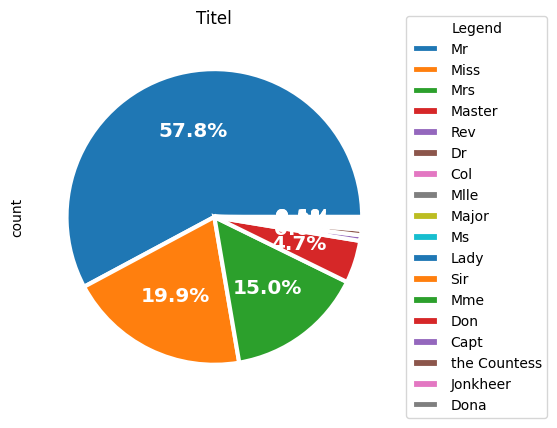

In [165]:
pie_chart = feature_engineering_df.Titel.value_counts().plot.pie(autopct='%.1f%%', 
                                                         wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, 
                                                         textprops=dict(size='x-large', color='white', fontweight='bold'))
pie_chart.set_title('Titel')

labels = feature_engineering_df.Titel.value_counts().index
plt.legend(labels, title="Legend", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

In [166]:
# Miss
feature_engineering_df['Titel'] = feature_engineering_df['Titel'].replace(['Mlle', 'Mme','Ms'], 'Miss')
# Mrs
feature_engineering_df['Titel'] = feature_engineering_df['Titel'].replace(['Lady','Countess','Dona'], 'Mrs')
# Mr
feature_engineering_df['Titel'] = feature_engineering_df['Titel'].replace(['Major', 'Col', 'Sir', 'Don', 'Jonkheer', 'Capt'], 'Mr')

# Titel als numerisches Feature
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
feature_engineering_df['Num_Titel'] = feature_engineering_df['Titel'].map(title_mapping)
feature_engineering_df.head(2)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Titel,First_Name,Sex,Num_Titel
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Train,Braund,Mr,Owen Harris,0,1.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Train,Cumings,Mrs,John Bradley,1,3.0


<a id="15"></a>
### Feature: Ist Kind

Unter der Premise Frauen und Kinder zuerst Wäre interesant zusehen ob du ein Kind bist oder nicht

In [ ]:
def calculate_points(row):
    if row['Age'] <= 8: # 8 Jahre haben sich beim ausprobieren als Sweetspot herausgestellt
        points = 1
    else:
        points = 0
    return points

# Neue Spalte 'Score' mit berechneten Punkten hinzufügen
feature_engineering_df['Is_Child'] = feature_engineering_df.apply(calculate_points, axis=1)

<a id="15"></a>
### Feature: Alter auffüllen

Mit Regression werden die Fehlenden alter aufgefüllt

In [167]:
# feature_engineering_df['Surname_encoded'] = label_encoder.fit_transform(feature_engineering_df['Surname'])
# feature_engineering_df['Titel_encoded'] = label_encoder.fit_transform(feature_engineering_df['Titel'])


# features = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Sex', 'Titel_encoded']

# # DataFrame, in dem Age bekannt ist
# df_known_age = feature_engineering_df.dropna(subset=['Age'])
# # DataFrame, in dem Age fehlt
# df_unknown_age = feature_engineering_df[feature_engineering_df['Age'].isnull()]


# # Initialisiere das Random Forest Modell
# model_rf = RandomForestRegressor(n_estimators=1500, random_state=42) # Du kannst mit diesen Parametern experimentieren

# # Wähle die Features und das Target für die Kreuzvalidierung aus
# X = df_known_age[features]
# y = df_known_age['Age']


# scores = cross_val_score(model_rf, X, y, cv=5, scoring='neg_mean_squared_error')
# # Konvertiere die Scores in positive Werte
# mse_scores = -scores
# print(f"Durchschnittlicher MSE: {mse_scores.mean()} (je kleiner, desto besser)")
# print(f"Standardabweichung der MSE: {mse_scores.std()} (je kleiner, desto besser)")


# # Trainiere das Modell mit den bekannten Alterswerten
# model_rf.fit(df_known_age[features], df_known_age['Age'])

# predicted_ages_rf = model_rf.predict(df_unknown_age[features])
# feature_engineering_df.loc[feature_engineering_df['Age'].isnull(), 'Age'] = predicted_ages_rf
# replace rare titles with more common ones


titles = list(feature_engineering_df.Titel.value_counts().index)

# for each title, impute missing age by the median of the persons with the same title
for title in titles:
    age_to_impute = feature_engineering_df.groupby('Titel')['Age'].median()[title]
    feature_engineering_df.loc[(feature_engineering_df['Age'].isnull()) & (feature_engineering_df['Titel'] == title), 'Age'] = age_to_impute

<a id="15"></a>
### Feature: Altersgruppen

In [ ]:
feature_engineering_df['AgeBin'] = pd.qcut(feature_engineering_df['Age'], 4)
label = LabelEncoder()
feature_engineering_df['AgeBin_Code'] = label.fit_transform(feature_engineering_df['AgeBin'])
feature_engineering_df.drop(['Age'], axis= 1, inplace=True)

<a id="8"></a>
### Feature: Familiengröße (Family_Size)

In [168]:
feature_engineering_df['Family_Size'] = (feature_engineering_df['SibSp'] + feature_engineering_df['Parch']+1)
feature_engineering_df.head(1)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Titel,First_Name,Sex,Num_Titel,Family_Size
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.25,NaN,S,Train,Braund,Mr,Owen Harris,0,1.0,2


Barplot mit mit der Verteilung der Familiengröße:

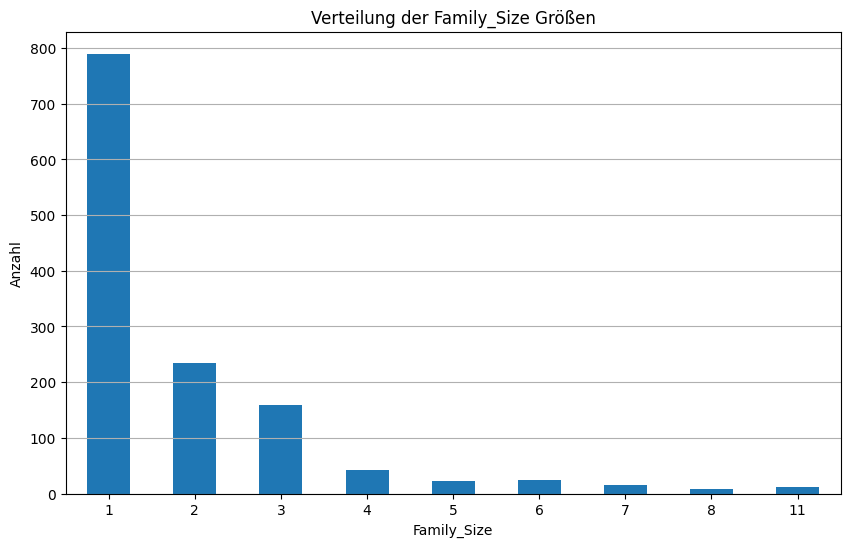

In [169]:
family_size_counts = feature_engineering_df['Family_Size'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
family_size_counts.plot(kind='bar')
plt.title('Verteilung der Family_Size Größen')
plt.xlabel('Family_Size')
plt.ylabel('Anzahl')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


Labeln der Familiengröße um das Feature zu vereinfachen:

In [170]:
def label_family_group(size):
    group = ''
    if (size <= 1):
        group = 'loner'
    elif (size <= 4):
        group = 'small'
    else:
        group = 'large'
    return group

feature_engineering_df['Family_Size_Label'] = feature_engineering_df['Family_Size'].apply(label_family_group)

# Numerisches Feature draus machen
feature_engineering_df['Family_Size_Label_encoded'] = label_encoder.fit_transform(feature_engineering_df['Family_Size_Label'])

feature_engineering_df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Titel,First_Name,Sex,Num_Titel,Family_Size,Family_Size_Label,Family_Size_Label_encoded
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Train,Braund,Mr,Owen Harris,0,1.0,2,small,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Train,Cumings,Mrs,John Bradley,1,3.0,2,small,2
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Train,Heikkinen,Miss,Laina,1,2.0,1,loner,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Train,Futrelle,Mrs,Jacques Heath,1,3.0,2,small,2
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Train,Allen,Mr,William Henry,0,1.0,1,loner,1


<a id="9"></a>
### Feature: Überlebensrate von Familien

Eine Familie wird wie folgt definiert:
Passagiere mit gleichem Nachname (Surname) gleichem Ticketpreis (Fare) und gleichem Ticket.

In [82]:
default_survival_value = 0.5
feature_engineering_df['Family_Survival'] = default_survival_value

for grp, grp_df in feature_engineering_df.groupby(['Surname', 'Fare']):
    # if a family group is found
    if (len(grp_df) != 1):
        # for every person, look for the other people from the same family
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            
            if (smax == 1.0): # if anyone in the family survived, assign 1
                feature_engineering_df.loc[feature_engineering_df['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0): # else if we saw someone dead, assign 0
                feature_engineering_df.loc[feature_engineering_df['PassengerId'] == passID, 'Family_Survival'] = 0

print("Number of passengers with family survival information:", 
      feature_engineering_df.loc[feature_engineering_df['Family_Survival']!=0.5].shape[0])

Number of passengers with family survival information: 420


In [83]:
# get information about family survival using the Ticket number

for _, grp_df in feature_engineering_df.groupby('Ticket'):
    # if a family group is found
    if (len(grp_df) != 1):
        # for every person, look for the other people from the same family
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0): # if anyone in the family survived, assign 1
                    feature_engineering_df.loc[feature_engineering_df['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0): # else if we saw someone dead, assign 0
                    feature_engineering_df.loc[feature_engineering_df['PassengerId'] == passID, 'Family_Survival'] = 0
                        
print("Number of passenger with family survival information: " 
      +str(feature_engineering_df[feature_engineering_df['Family_Survival']!=0.5].shape[0]))

Number of passenger with family survival information: 546


In [84]:
# Funktion, um Punkte basierend auf dem Geschlecht und dem Alter zu berechnen
def calculate_points(row):
    if row['Age'] <= 8:
        points = 1
    else:
        points = 0
    return points

# Neue Spalte 'Score' mit berechneten Punkten hinzufügen
feature_engineering_df['Is_Child'] = feature_engineering_df.apply(calculate_points, axis=1)

# Funktion, um Punkte basierend auf dem Geschlecht und dem Alter zu berechnen
def calculate_points(row):
    if row['Embarked'] == "C":
        points = 1
    else:
        points = 0
    return points

# Neue Spalte 'Score' mit berechneten Punkten hinzufügen
feature_engineering_df['Is_from_Cherbourg'] = feature_engineering_df.apply(calculate_points, axis=1)


<a id="11"></a>
## Data Preprocessing 

In [85]:
# fare bins
feature_engineering_df['FareBin'] = pd.qcut(feature_engineering_df['Fare'], 5)
label = LabelEncoder()
feature_engineering_df['FareBin_Code'] = label.fit_transform(feature_engineering_df['FareBin'])
feature_engineering_df.drop(['Fare'], inplace=True, axis=1)
# # age bins
# feature_engineering_df['AgeBin'] = pd.qcut(feature_engineering_df['Age'], 4)
# label = LabelEncoder()
# feature_engineering_df['AgeBin_Code'] = label.fit_transform(feature_engineering_df['AgeBin'])
# feature_engineering_df.drop(['Age'], axis= 1, inplace=True)

FRISCH MACHEN!!

In [86]:
# choose features and labels
label = "Survived"
features = ["Pclass", "Sex", "Family_Size", "Family_Survival", "FareBin_Code", "AgeBin_Code"]

# split back feature_engineering_df into train and prediction sets
train_df = feature_engineering_df[feature_engineering_df["Dataset"] == "Train"][features + [label]]
test_df = feature_engineering_df[feature_engineering_df["Dataset"] == "Test"][features]

# convert Survived variable to int for train dataset
train_df["Survived"] = train_df["Survived"].astype(np.int64)

In [87]:
train_df.head()

,Pclass,Sex,Family_Size,Family_Survival,FareBin_Code,AgeBin_Code,Survived
0,3,0,2,0.5,0,0,0
1,1,1,2,0.5,4,3,1
2,3,1,1,0.5,1,1,1
3,1,1,2,0.0,4,2,1
4,3,0,1,0.5,1,2,0


In [88]:
test_df.head()

,Pclass,Sex,Family_Size,Family_Survival,FareBin_Code,AgeBin_Code
891,3,0,1,0.5,0,2
892,3,1,2,0.5,0,3
893,2,0,1,0.5,1,3
894,3,0,1,0.5,1,1
895,3,1,3,1.0,2,0


<a id="12"></a>
## Modells

<a id="x"></a>
### K-Nearest Neighbors 

<a id="13"></a>
#### Modell-Setup 

In [89]:
# setup dataframes
X = train_df[features]
y = train_df['Survived']
X_pred = test_df

# scale data for KNN classifier
std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)
X_pred = std_scaler.transform(X_pred)

In [90]:
# setup parameters values for grid search
n_neighbors = [6,7,8,9,10,11,12,14,16,18,20,22]
weights = ['uniform', 'distance']
leaf_size = list(range(1,50,5))
hyperparams = {'weights': weights, 'leaf_size': leaf_size, 'n_neighbors': n_neighbors}


gd=GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, verbose=True, 
                cv=10, scoring = "roc_auc")

<a id="14"></a>
#### Modell-Training 

In [91]:
gd.fit(X, y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


0.8783650227767875
KNeighborsClassifier(leaf_size=26, n_neighbors=16)


<a id="15"></a>
#### Modell-Prediction

In [92]:
# make predictions
gd.best_estimator_.fit(X, y)
y_pred = gd.best_estimator_.predict(X_pred)

In [93]:
# output predictions dataframe
temp = pd.DataFrame(pd.read_csv(data_path/'../csv/original_data/test.csv')['PassengerId'])
temp['Survived'] = y_pred
temp.to_csv("submission_test.csv", index = False)